In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# sklearn 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV     
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score,r2_score
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, auc
from sklearn.metrics import precision_recall_curve, roc_curve, classification_report

# lightgbm
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

import missingno as msno
import plotly.express as px


In [59]:
df = pd.read_csv("pd_speech_features.csv", index_col=0, delimiter = ',',
                skiprows=1)
df.head()

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
id,,,,,,,,,,,,,,,,,,,,,
0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,0.000044,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


In [60]:
df = df.loc[:,~df.columns.duplicated()]

In [61]:
df=df.sample(frac=1).reset_index(drop=True)

In [62]:
df.apply(lambda x: sum(x.isnull()),axis=0)

gender                       0
PPE                          0
DFA                          0
RPDE                         0
numPulses                    0
                            ..
tqwt_kurtosisValue_dec_33    0
tqwt_kurtosisValue_dec_34    0
tqwt_kurtosisValue_dec_35    0
tqwt_kurtosisValue_dec_36    0
class                        0
Length: 754, dtype: int64

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 754 entries, gender to class
dtypes: float64(749), int64(5)
memory usage: 4.3 MB


In [64]:
df.describe()

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,7.560000e+02,...,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,0.515873,0.746284,0.700414,0.489058,323.972222,322.678571,0.006360,0.000383,0.002324,1.673391e-05,...,26.237251,22.840337,18.587888,13.872018,12.218953,12.375335,14.799230,14.751559,31.481110,0.746032
std,0.500079,0.169294,0.069718,0.137442,99.219059,99.402499,0.001826,0.000728,0.002628,2.290134e-05,...,42.220693,32.626464,25.537464,20.046029,17.783642,16.341665,15.722502,14.432979,34.230991,0.435568
min,0.000000,0.041551,0.543500,0.154300,2.000000,1.000000,0.002107,0.000011,0.000210,6.860000e-07,...,1.509800,1.531700,1.582900,1.747200,1.789500,1.628700,1.861700,1.955900,2.364000,0.000000
25%,0.000000,0.762833,0.647053,0.386537,251.000000,250.000000,0.005003,0.000049,0.000970,5.260000e-06,...,2.408675,3.452800,3.354825,3.077450,2.937025,3.114375,3.665925,3.741275,3.948750,0.000000
50%,1.000000,0.809655,0.700525,0.484355,317.000000,316.000000,0.006048,0.000077,0.001495,9.530000e-06,...,5.586300,7.062750,6.077400,4.770850,4.300450,4.741450,6.725700,7.334250,10.637250,1.000000
75%,1.000000,0.834315,0.754985,0.586515,384.250000,383.250000,0.007528,0.000171,0.002520,1.832500e-05,...,28.958075,29.830850,21.944050,13.188000,10.876150,12.201325,21.922050,22.495175,61.125325,1.000000
max,1.000000,0.907660,0.852640,0.871230,907.000000,905.000000,0.012966,0.003483,0.027750,2.564800e-04,...,239.788800,203.311300,121.542900,102.207000,85.571700,73.532200,62.007300,57.544300,156.423700,1.000000


In [65]:
df.columns

Index(['gender', 'PPE', 'DFA', 'RPDE', 'numPulses', 'numPeriodsPulses',
       'meanPeriodPulses', 'stdDevPeriodPulses', 'locPctJitter',
       'locAbsJitter',
       ...
       'tqwt_kurtosisValue_dec_28', 'tqwt_kurtosisValue_dec_29',
       'tqwt_kurtosisValue_dec_30', 'tqwt_kurtosisValue_dec_31',
       'tqwt_kurtosisValue_dec_32', 'tqwt_kurtosisValue_dec_33',
       'tqwt_kurtosisValue_dec_34', 'tqwt_kurtosisValue_dec_35',
       'tqwt_kurtosisValue_dec_36', 'class'],
      dtype='object', length=754)

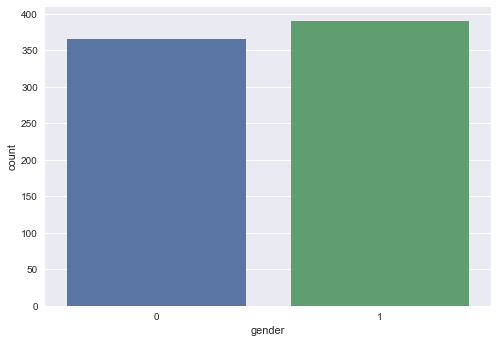

In [66]:
sns.countplot(data = df, x = 'gender');

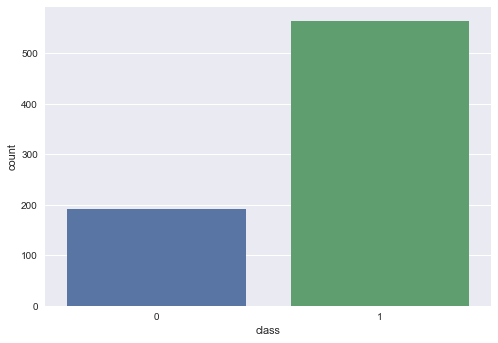

In [67]:
sns.countplot(data = df, x = 'class');

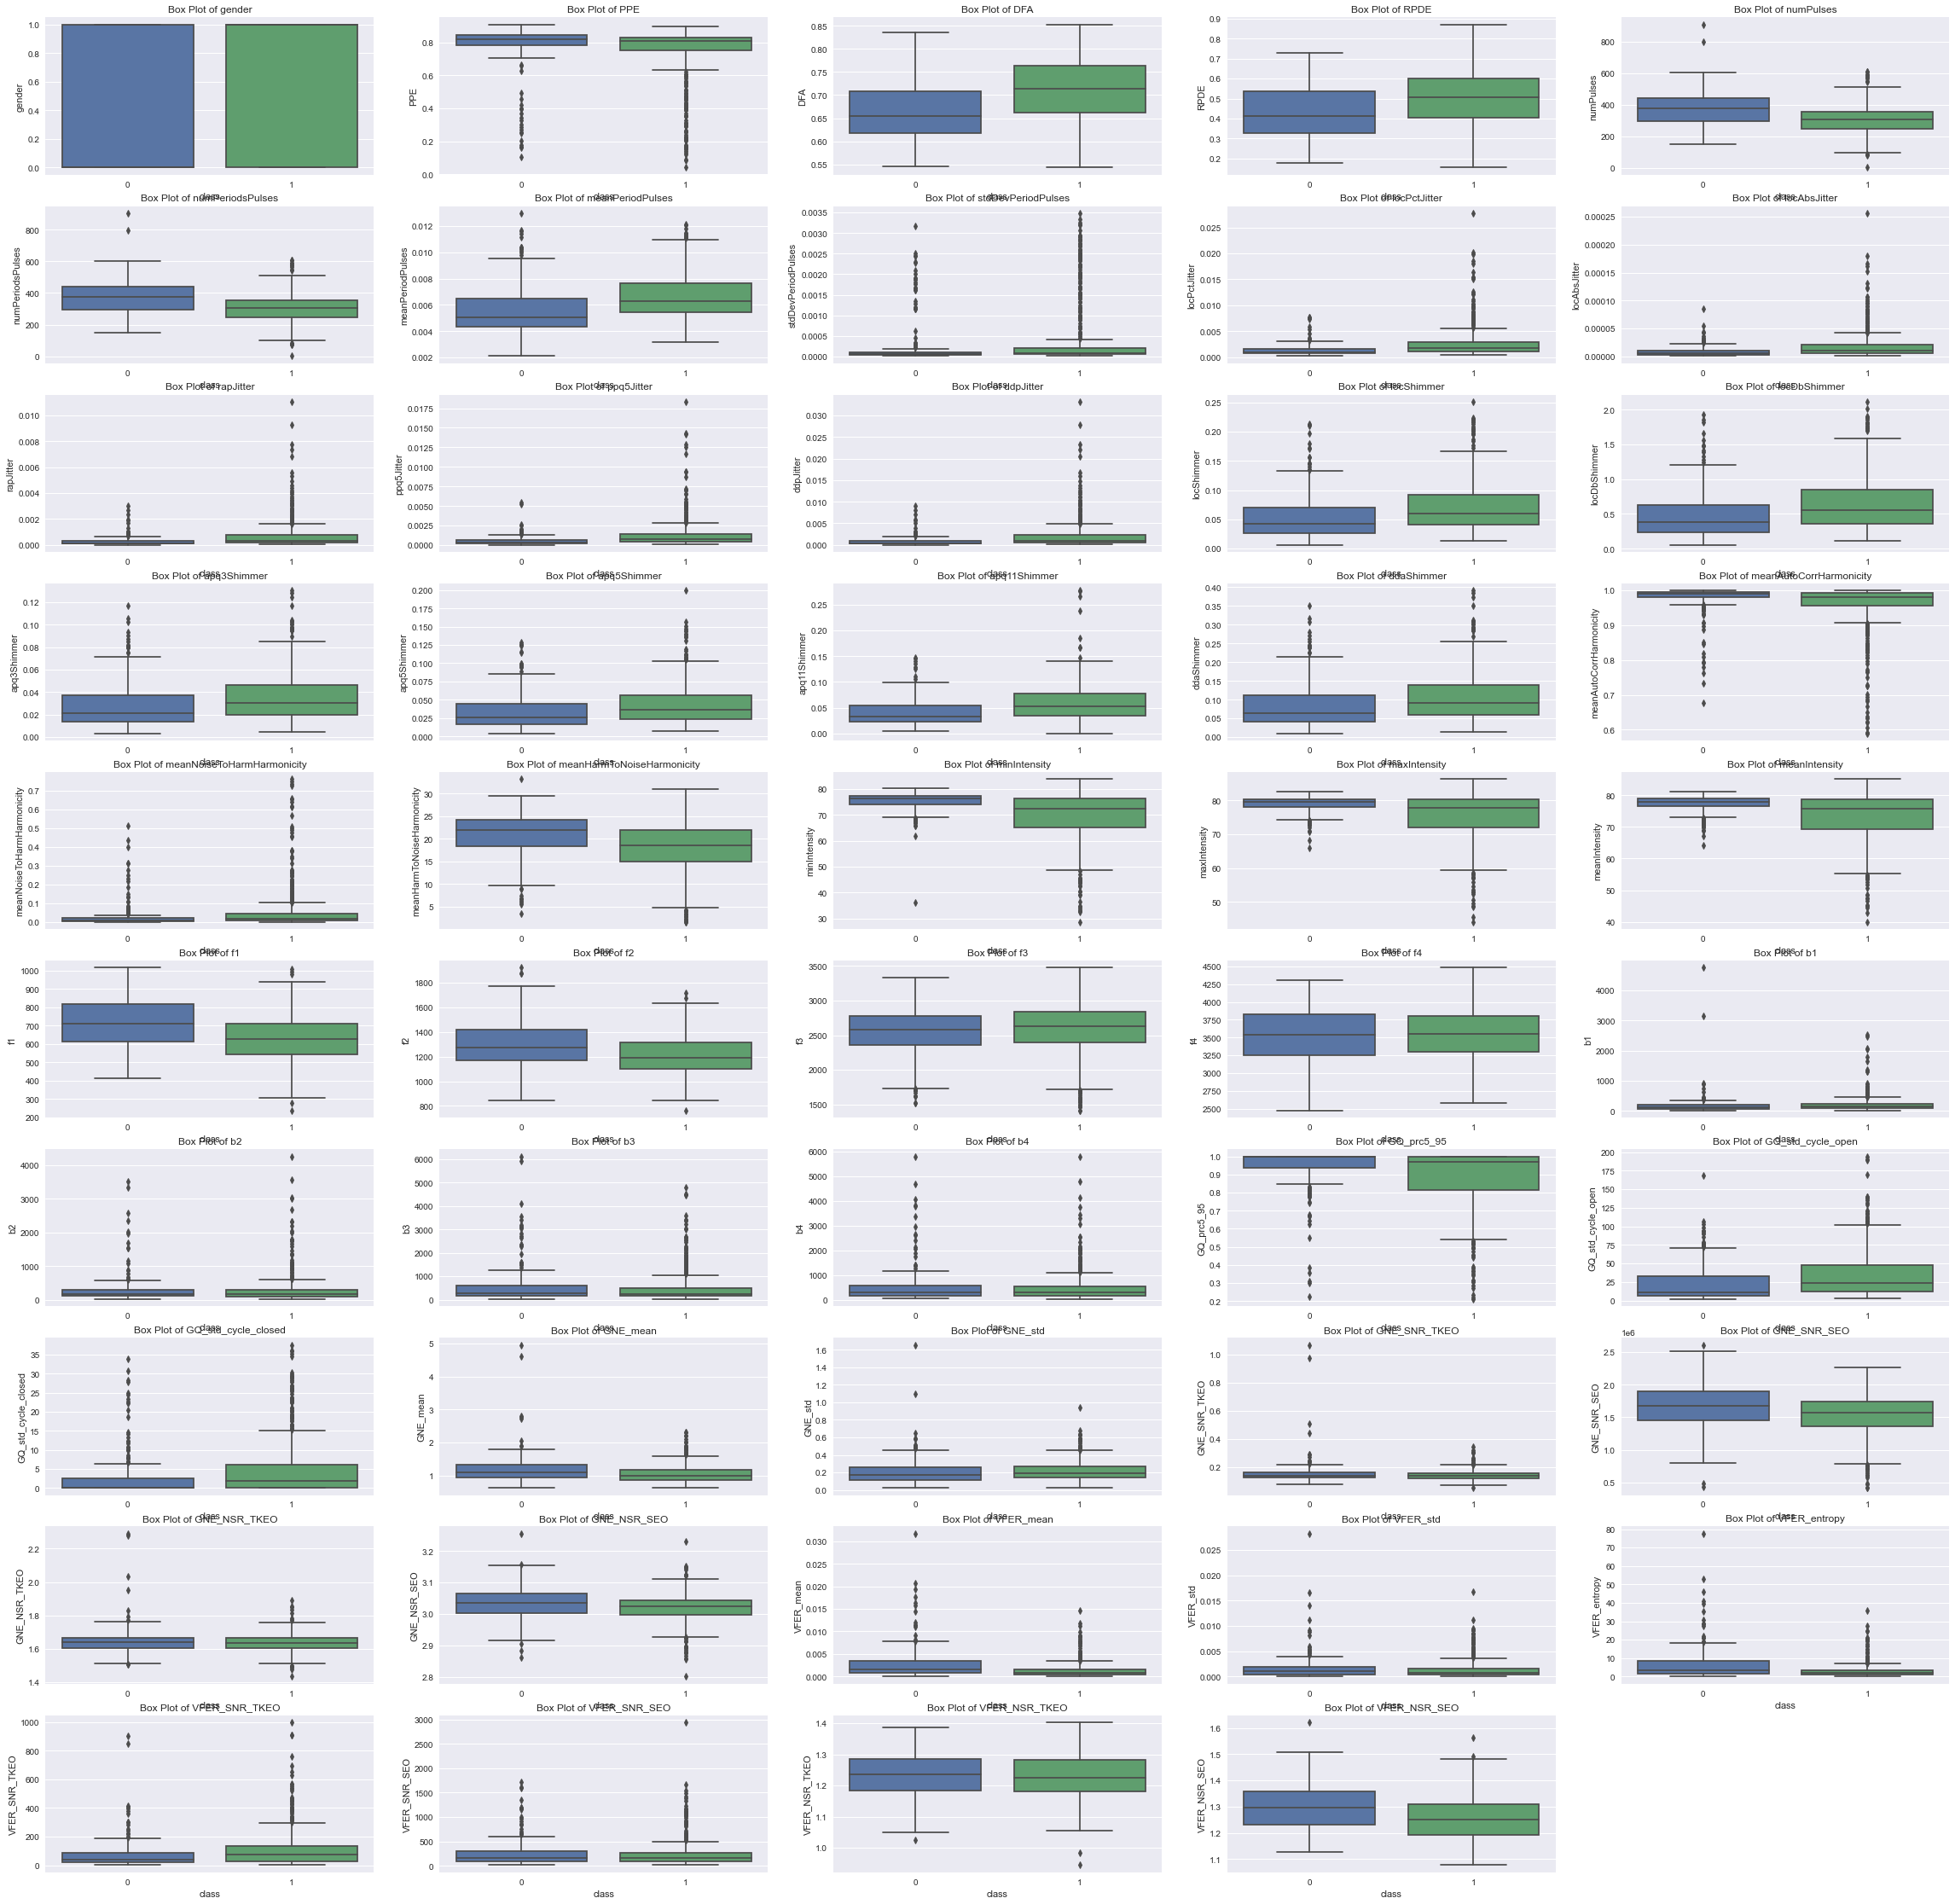

In [68]:
i = 1
plt.figure(figsize=(40,40))
for c in df.columns[:49]:
    plt.subplot(10,5,i)
    plt.title(f"Box Plot of {c}")
    plt.yticks()
    plt.xticks()
    sns.boxplot(y=df[c], x = df['class'])
    i +=1
plt.show()

In [69]:
X = df.drop('class', axis=1)
y = df['class']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
X_train.shape

(604, 753)

In [72]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [73]:
def plot_roc(fpr, tpr, roc_auc):
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='salmon',label= 'AUC = %0.2f'% roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0,1],[0,1], linestyle = '--')
    plt.axis('tight')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

In [75]:
X_train.shape

(604, 753)

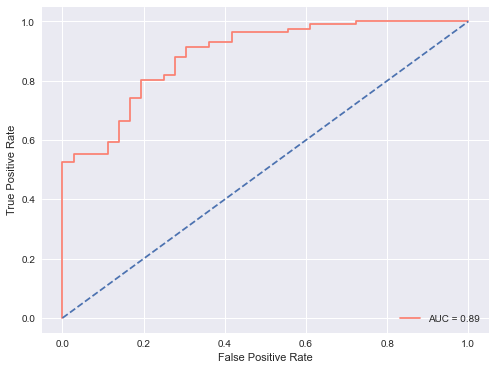

In [76]:
lr = LogisticRegression(C=0.1,random_state = 42)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1])
roc_auc = auc(fpr, tpr)
plot_roc(fpr,tpr, roc_auc)

In [77]:
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Logistic Train Score: ", format(lr.score(X_test, y_test)))

Accuracy:  0.8618421052631579
Logistic Train Score:  0.8618421052631579


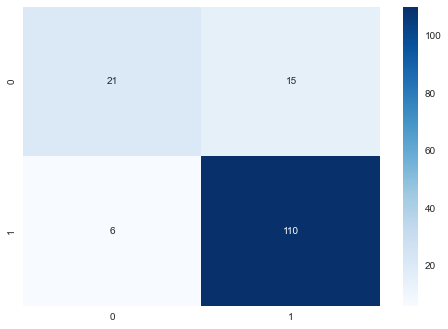

In [78]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = "Blues" ,fmt = 'd');

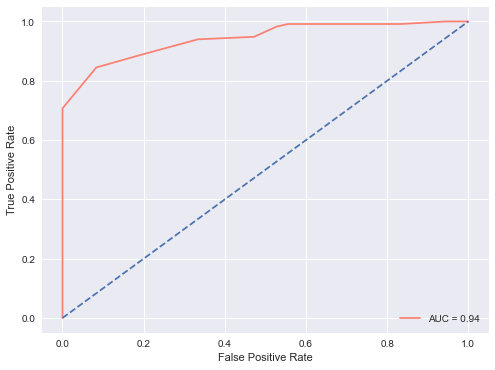

In [79]:
model = KNeighborsClassifier(n_jobs = 2, n_neighbors=22)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr, )
plot_roc(fpr, tpr, roc_auc)

In [80]:
print("Accuracy_score: ", accuracy_score(y_test, y_pred))
print("KNN train score: ", format(model.score(X_train, y_train)))
print('KNN test score: ', format(model.score(X_test, y_test)))

Accuracy_score:  0.8618421052631579
KNN train score:  0.8228476821192053
KNN test score:  0.8618421052631579


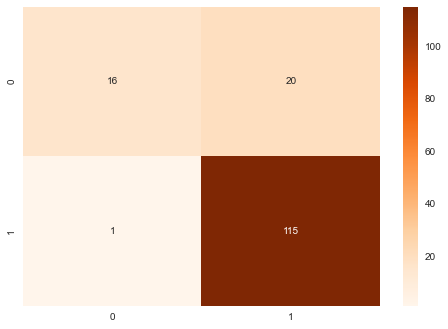

In [81]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = "Oranges" ,fmt = 'd');

In [82]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.44      0.60        36
           1       0.85      0.99      0.92       116

    accuracy                           0.86       152
   macro avg       0.90      0.72      0.76       152
weighted avg       0.87      0.86      0.84       152



# Deep Neural Network 

In [83]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.optimizers import RMSprop, Adam

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [92]:
model = Sequential()
model.add(Dense(64, input_dim = X_train.shape[1], activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# output layer
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam',metrics = ['accuracy'])

In [93]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                48256     
_________________________________________________________________
module_wrapper_9 (ModuleWrap (None, 64)                256       
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               33024     
_________________________________________________________________
module_wrapper_10 (ModuleWra (None, 256)              

In [109]:
History = model.fit(X_train,y_train ,batch_size=100, epochs = 10, verbose=1)
History

Epoch 1/10
7/7 [==============================] - 0s 20ms/step - loss: 0.1749 - accuracy: 0.9272
Epoch 2/10
7/7 [==============================] - 0s 15ms/step - loss: 0.2038 - accuracy: 0.9205
Epoch 3/10
7/7 [==============================] - 0s 17ms/step - loss: 0.2154 - accuracy: 0.9123
Epoch 4/10
7/7 [==============================] - 0s 16ms/step - loss: 0.1910 - accuracy: 0.9205
Epoch 5/10
7/7 [==============================] - 0s 14ms/step - loss: 0.1815 - accuracy: 0.9338
Epoch 6/10
7/7 [==============================] - 0s 18ms/step - loss: 0.2390 - accuracy: 0.9023
Epoch 7/10
7/7 [==============================] - 0s 18ms/step - loss: 0.1768 - accuracy: 0.9338
Epoch 8/10
7/7 [==============================] - 0s 16ms/step - loss: 0.2061 - accuracy: 0.9172
Epoch 9/10
7/7 [==============================] - 0s 15ms/step - loss: 0.2055 - accuracy: 0.9255
Epoch 10/10
7/7 [==============================] - 0s 23ms/step - loss: 0.1822 - accuracy: 0.9255


Text(0.5, 1.0, 'Traning and Validation Accuracy')

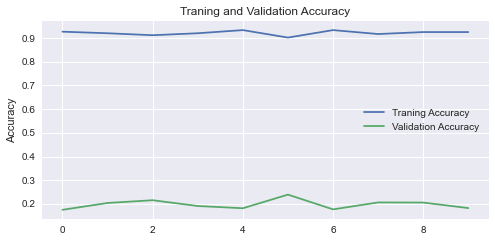

In [110]:
acc = History.history['accuracy']

loss = History.history['loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label = 'Traning Accuracy')
plt.plot(loss, label = 'Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.title('Traning and Validation Accuracy')